<div style=" width: 100%; background: #2B547E; padding: 20px 0; text-align: center; color: #fff; font: sans-serif; border-radius: 10px;">
    <h1 style="font-size: 24; font-weight: 900">پروژه‌ی درس یادگیری عمیق</h1>
    <h2 style="font-size: 24; font-weight: 400">طبقه‌بندی تصاویر حیوان خانگی</h2>
</div>

<div style=" width: 100%; background: #3d6a9a; padding: 20px 0; color: #fff; font: sans-serif; border-radius: 15px;">
    <h3 style="font-size: 20; font-weight: 400; text-align: center">اعضای گروه</h3>
    <ul style="width: 50%; direction: rtl; ">
        <li>مهریار محرابی</li>
        <li>علی‌رضا پالیده</li>
    </ul>
</div>

In [170]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import ConcatDataset, Subset, random_split, DataLoader, Dataset
from collections import Counter
from tqdm import tqdm
import numpy as np
import timm
from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import hiddenlayer as hl

<h1 style="color: #2B547E; font-weight: bold;">Custom CNN</h1>


In [171]:
numClasses = 37
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [172]:
dataset_root = './data'

trainDataset = OxfordIIITPet(
    root=dataset_root,
    split='trainval',
    target_types='category',
    download=True
)
testDataset = OxfordIIITPet(
    root='./data',
    split='test',
    target_types='category',
    transform=None,
    download=True
)

dataset = ConcatDataset([trainDataset, testDataset])
print(f"Total images in the combined dataset: {len(dataset)}")

Total images in the combined dataset: 7349


In [173]:
print("Files in dataset root:")
print(os.listdir(dataset_root))

Files in dataset root:
['oxford-iiit-pet']


In [174]:
selectedClasses = list(range(numClasses))
labels = [i for i, (_, label) in enumerate(dataset) if label in selectedClasses]
subset = Subset(dataset, labels)

labels = [label for _, label in Subset(dataset, labels)]
classes = Counter(labels)

for classLabel, count in sorted(classes.items()):
    print(f"Class {classLabel+1}: {count} images")

Class 1: 198 images
Class 2: 200 images
Class 3: 200 images
Class 4: 200 images
Class 5: 200 images
Class 6: 200 images
Class 7: 200 images
Class 8: 184 images
Class 9: 199 images
Class 10: 200 images
Class 11: 200 images
Class 12: 190 images
Class 13: 196 images
Class 14: 200 images
Class 15: 200 images
Class 16: 200 images
Class 17: 200 images
Class 18: 200 images
Class 19: 199 images
Class 20: 200 images
Class 21: 200 images
Class 22: 200 images
Class 23: 196 images
Class 24: 200 images
Class 25: 200 images
Class 26: 200 images
Class 27: 200 images
Class 28: 200 images
Class 29: 200 images
Class 30: 200 images
Class 31: 199 images
Class 32: 200 images
Class 33: 199 images
Class 34: 200 images
Class 35: 189 images
Class 36: 200 images
Class 37: 200 images


In [175]:
trainSize = int(0.8 * len(subset))
valSize = len(subset) - trainSize
trainDataset, valDataset = random_split(subset, [trainSize, valSize])
print(f"Number of Training Images: {len(trainDataset)}")
print(f"Number of Validation Images: {len(valDataset)}")

Number of Training Images: 5879
Number of Validation Images: 1470


In [176]:
trainLabels = [label for _, label in trainDataset]
valLabels = [label for _, label in valDataset]
trainClassCount = Counter(trainLabels)
valClassCount = Counter(valLabels)

print("Number Of Image In Training Set:")
for classId, count in sorted(trainClassCount.items()):
    print(f"Class {classId}: {count} images")

print("\nNumber Of Image In Test Set:")
for classId, count in sorted(valClassCount.items()):
    print(f"Class {classId}: {count} images")

Number Of Image In Training Set:
Class 0: 152 images
Class 1: 159 images
Class 2: 152 images
Class 3: 154 images
Class 4: 162 images
Class 5: 160 images
Class 6: 160 images
Class 7: 145 images
Class 8: 165 images
Class 9: 159 images
Class 10: 164 images
Class 11: 149 images
Class 12: 161 images
Class 13: 158 images
Class 14: 164 images
Class 15: 156 images
Class 16: 160 images
Class 17: 165 images
Class 18: 158 images
Class 19: 160 images
Class 20: 158 images
Class 21: 162 images
Class 22: 156 images
Class 23: 160 images
Class 24: 155 images
Class 25: 159 images
Class 26: 162 images
Class 27: 159 images
Class 28: 158 images
Class 29: 159 images
Class 30: 161 images
Class 31: 157 images
Class 32: 158 images
Class 33: 173 images
Class 34: 152 images
Class 35: 169 images
Class 36: 158 images

Number Of Image In Test Set:
Class 0: 46 images
Class 1: 41 images
Class 2: 48 images
Class 3: 46 images
Class 4: 38 images
Class 5: 40 images
Class 6: 40 images
Class 7: 39 images
Class 8: 34 images

In [177]:
class OxfordPetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype = torch.long)

In [178]:
trainTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4813, 0.4496, 0.3964], std=[0.2274, 0.2247, 0.2267])
])

valTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4813, 0.4496, 0.3964], std=[0.2274, 0.2247, 0.2267])
])

In [179]:
trainDataset = OxfordPetDataset(
    dataset = trainDataset,
    transform = trainTransforms
)

valDataset = OxfordPetDataset(
    dataset = valDataset,
    transform = valTransforms
)

image, label = trainDataset[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 224, 224])
Label: 11


In [180]:
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, pin_memory=True)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False, pin_memory=True)

print(f"Number of Batches in Train Loader: {len(trainLoader)}")
print(f"Number of Batches in Val Loader: {len(valLoader)}")

Number of Batches in Train Loader: 92
Number of Batches in Val Loader: 23


In [181]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, calsses, normalize=True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 20))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

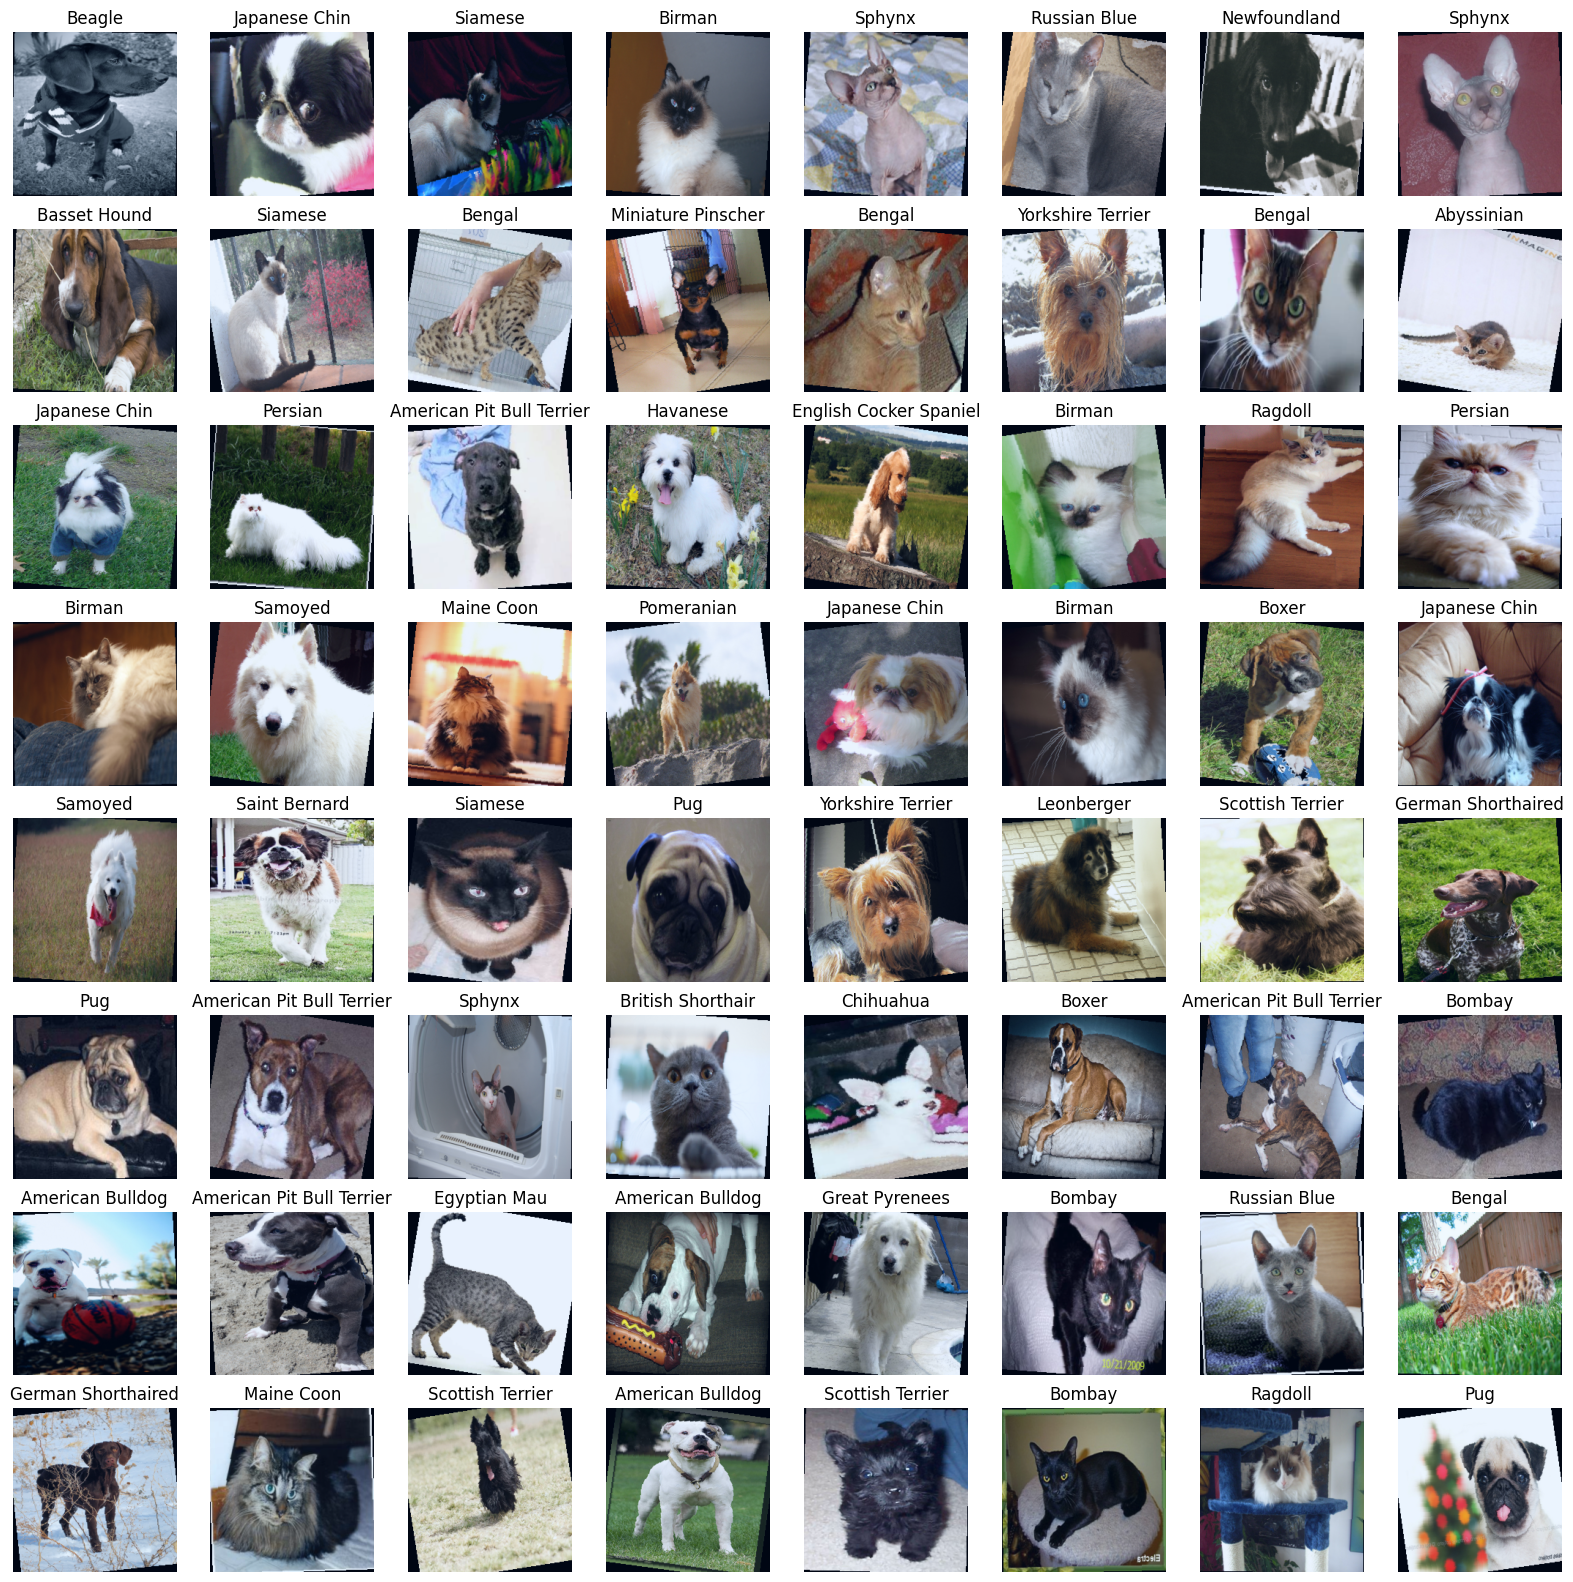

In [182]:
classes = testDataset.classes
batchs = next(iter(trainLoader))
plot_images(batchs[0], batchs[1], classes)

In [183]:
images, labels = next(iter(trainLoader))
print(f"Image Batch Shape: {images.shape}")
print(f"Label Batch Shape: {labels.shape}")

Image Batch Shape: torch.Size([64, 3, 224, 224])
Label Batch Shape: torch.Size([64])


In [184]:
class CustomCNN(nn.Module):
    def __init__(self, numClasses):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding='same'),  
            nn.SiLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=5, padding='same'),  
            nn.SiLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),  
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),  
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),  
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'), 
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding='same'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(256, 512, kernel_size=5, padding=2),  
        #     nn.SiLU(),
        #     nn.BatchNorm2d(512),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )

        # self.conv6 = nn.Sequential(
        #     nn.Conv2d(256, 512, kernel_size=2, padding=1),  
        #     nn.SiLU(),
        #     nn.BatchNorm2d(512),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )

        # self.conv7 = nn.Sequential(  
        #     nn.Conv2d(512, 512, kernel_size=3, padding=1), 
        #     nn.BatchNorm2d(512),
        #     nn.SiLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )


        self.AvgPooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, numClasses)


        self.dropout_conv = nn.Dropout(0.1)
        self.dropout_fc = nn.Dropout(0.2)
        self.LR = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.dropout_conv(self.conv1(x))
        x = self.dropout_conv(self.conv2(x))
        x = self.dropout_conv(self.conv3(x))
        x = self.dropout_conv(self.conv4(x))
        # x = self.dropout_conv(self.conv5(x))
        # x = self.dropout_conv(self.conv6(x))
        # x = self.dropout_conv(self.conv7(x))

        x = self.AvgPooling(x).view(x.size(0), -1)

        x = self.LR(self.fc1(x))
        x = self.dropout_fc(x)

        return x

In [185]:
from torch.utils.tensorboard import SummaryWriter

try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir runs --host localhost --port 8088
else:
  print('To Use tensorboard, Use Google Colab Environment!')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8088 (pid 2633), started 0:29:10 ago. (Use '!kill 2633' to kill it.)

<IPython.core.display.Javascript object>

In [186]:
#writer = SummaryWriter()
model = CustomCNN(numClasses=numClasses)
#batcha = torch.rand(1,3,224,224)
#writer.add_graph(model, batcha)
#writer.close()

summary(model, input_size = (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [1, 37]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         2,432
│    └─SiLU: 2-2                         [1, 32, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 224, 224]         64
│    └─Conv2d: 2-4                       [1, 32, 224, 224]         25,632
│    └─SiLU: 2-5                         [1, 32, 224, 224]         --
│    └─BatchNorm2d: 2-6                  [1, 32, 224, 224]         64
│    └─MaxPool2d: 2-7                    [1, 32, 112, 112]         --
├─Dropout: 1-2                           [1, 32, 112, 112]         --
├─Sequential: 1-3                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 64, 112, 112]         18,496
│    └─SiLU: 2-9                         [1, 64, 112, 112]         --
│   

In [187]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, valLoss):
        if self.best_loss is None:
            self.best_loss = valLoss
        elif valLoss < self.best_loss - self.delta:
            self.best_loss = valLoss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop

In [188]:
def validate_model(model, valLoader, LossFunc):
    model.eval()
    valLoss = 0.0
    totalSamples = 0
    totalCorrect = 0
    valBar = tqdm(valLoader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, labels in valBar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = LossFunc(outputs, labels)
            valLoss += loss.item()

            predictions = torch.argmax(outputs, dim=1)

            totalCorrect += (predictions == labels).sum().item()
            totalSamples += labels.size(0)

            valBar.set_postfix(loss=loss.item())

    avg_valLoss = valLoss / len(valLoader)
    accuracy = 100 * totalCorrect / totalSamples
    return avg_valLoss, accuracy

In [200]:
def train_model(model, trainLoader, valLoader, LossFunc, optimizer, scheduler=None, num_epochs = 20, patience=5, ModelName='cnn'):
    scaler = torch.amp.GradScaler('cuda')
    earlyStopping = EarlyStopping(patience=patience)

    writer = SummaryWriter(f'runs/{ModelName}')
    #history = {'trainLoss': [], 'trainAccuracy': [], 'valLoss': [], 'valAccuracy': []}

    if len(trainLoader) == 0 or len(valLoader) == 0:
        print("Training or validation loader is empty. Skipping training.")
        return

    for epoch in range(num_epochs):
        model.train()
        running_trainLoss = 0.0
        totalCorrect = 0
        totalSamples = 0


        train_bar = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = LossFunc(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_trainLoss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            totalCorrect += (predictions == labels).sum().item()
            totalSamples += labels.size(0)

            train_bar.set_postfix(loss=loss.item())

        trainLoss = running_trainLoss / len(trainLoader)
        trainAccuracy = 100 * totalCorrect / totalSamples

        writer.add_scalar('train/Loss', trainLoss, epoch+1)
        writer.add_scalar('train/ACC', trainAccuracy, epoch+1)

        valLoss, valAccuracy = validate_model(model, valLoader, LossFunc)

        writer.add_scalar('val/Loss', valLoss, epoch+1)
        writer.add_scalar('val/ACC', valAccuracy, epoch+1)

        print(f"\nEpoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.2f}%, "
              f"Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.2f}%")


        if scheduler is not None:
            scheduler.step(valLoss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        if earlyStopping(valLoss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print("training complete.")
    writer.close()

In [190]:
if device == 'cuda':
  model = nn.DataParallel(model)
model = model.to(device)

LossFunc = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0003, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

In [191]:
 train_model(model, trainLoader, valLoader, LossFunc, optimizer, scheduler , num_epochs=100, patience=10)

Epoch 1/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.24it/s, loss=3.46]



Epoch [1/100], Train Loss: 3.5628, Train Accuracy: 6.55%, Val Loss: 3.5021, Val Accuracy: 6.33%
Learning Rate: 0.000300


Epoch 2/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=3.35]



Epoch [2/100], Train Loss: 3.4611, Train Accuracy: 9.12%, Val Loss: 3.4337, Val Accuracy: 9.39%
Learning Rate: 0.000300


Epoch 3/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=3.4] 



Epoch [3/100], Train Loss: 3.3588, Train Accuracy: 11.46%, Val Loss: 3.2787, Val Accuracy: 12.72%
Learning Rate: 0.000300


Epoch 4/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=3.26]



Epoch [4/100], Train Loss: 3.2493, Train Accuracy: 15.56%, Val Loss: 3.2532, Val Accuracy: 13.20%
Learning Rate: 0.000300


Epoch 5/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.24it/s, loss=3.2] 



Epoch [5/100], Train Loss: 3.1344, Train Accuracy: 19.25%, Val Loss: 3.1063, Val Accuracy: 14.90%
Learning Rate: 0.000300


Epoch 6/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.24it/s, loss=2.84]



Epoch [6/100], Train Loss: 3.0064, Train Accuracy: 22.96%, Val Loss: 3.0120, Val Accuracy: 21.90%
Learning Rate: 0.000300


Epoch 7/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=3.04]



Epoch [7/100], Train Loss: 2.8857, Train Accuracy: 25.94%, Val Loss: 2.7816, Val Accuracy: 24.29%
Learning Rate: 0.000300


Epoch 8/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=2.86]



Epoch [8/100], Train Loss: 2.7830, Train Accuracy: 29.92%, Val Loss: 2.5618, Val Accuracy: 32.04%
Learning Rate: 0.000300


Epoch 9/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=2.33]



Epoch [9/100], Train Loss: 2.6716, Train Accuracy: 33.05%, Val Loss: 2.4722, Val Accuracy: 33.13%
Learning Rate: 0.000300


Epoch 10/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=2.66]



Epoch [10/100], Train Loss: 2.6004, Train Accuracy: 34.97%, Val Loss: 2.4037, Val Accuracy: 36.73%
Learning Rate: 0.000300


Epoch 11/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.23it/s, loss=2.69]



Epoch [11/100], Train Loss: 2.5254, Train Accuracy: 37.08%, Val Loss: 2.4930, Val Accuracy: 32.52%
Learning Rate: 0.000300


Epoch 12/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=2.21]



Epoch [12/100], Train Loss: 2.4519, Train Accuracy: 40.53%, Val Loss: 2.2407, Val Accuracy: 43.40%
Learning Rate: 0.000300


Epoch 13/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.22it/s, loss=2.64]



Epoch [13/100], Train Loss: 2.3937, Train Accuracy: 42.06%, Val Loss: 2.1264, Val Accuracy: 46.39%
Learning Rate: 0.000300


Epoch 14/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=2.28]



Epoch [14/100], Train Loss: 2.2620, Train Accuracy: 45.71%, Val Loss: 1.9811, Val Accuracy: 50.61%
Learning Rate: 0.000300


Epoch 15/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.23it/s, loss=2.24]



Epoch [15/100], Train Loss: 2.1646, Train Accuracy: 48.73%, Val Loss: 1.8919, Val Accuracy: 51.84%
Learning Rate: 0.000300


Epoch 16/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=2.36]



Epoch [16/100], Train Loss: 2.0944, Train Accuracy: 51.59%, Val Loss: 2.0634, Val Accuracy: 49.25%
Learning Rate: 0.000300


Epoch 17/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=2.31]



Epoch [17/100], Train Loss: 2.0808, Train Accuracy: 52.46%, Val Loss: 1.8120, Val Accuracy: 54.49%
Learning Rate: 0.000300


Epoch 18/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.77]



Epoch [18/100], Train Loss: 1.9681, Train Accuracy: 55.01%, Val Loss: 1.7903, Val Accuracy: 54.69%
Learning Rate: 0.000300


Epoch 19/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=2.42]



Epoch [19/100], Train Loss: 1.9100, Train Accuracy: 56.30%, Val Loss: 1.6628, Val Accuracy: 61.97%
Learning Rate: 0.000300


Epoch 20/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.24it/s, loss=1.85]



Epoch [20/100], Train Loss: 1.8505, Train Accuracy: 58.28%, Val Loss: 1.6595, Val Accuracy: 57.76%
Learning Rate: 0.000300


Epoch 21/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=1.94]



Epoch [21/100], Train Loss: 1.7773, Train Accuracy: 60.79%, Val Loss: 1.6456, Val Accuracy: 63.20%
Learning Rate: 0.000300


Epoch 22/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=1.67]



Epoch [22/100], Train Loss: 1.7652, Train Accuracy: 60.50%, Val Loss: 1.6334, Val Accuracy: 60.14%
Learning Rate: 0.000300


Epoch 23/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=1.84]



Epoch [23/100], Train Loss: 1.7379, Train Accuracy: 61.54%, Val Loss: 1.4410, Val Accuracy: 64.56%
Learning Rate: 0.000300


Epoch 24/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.29it/s, loss=2.03]



Epoch [24/100], Train Loss: 1.6723, Train Accuracy: 63.34%, Val Loss: 1.3877, Val Accuracy: 66.39%
Learning Rate: 0.000300


Epoch 25/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.98]



Epoch [25/100], Train Loss: 1.6489, Train Accuracy: 63.94%, Val Loss: 1.3797, Val Accuracy: 65.92%
Learning Rate: 0.000300


Epoch 26/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.33]



Epoch [26/100], Train Loss: 1.5946, Train Accuracy: 65.27%, Val Loss: 1.3741, Val Accuracy: 66.87%
Learning Rate: 0.000300


Epoch 27/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.21it/s, loss=1.38]



Epoch [27/100], Train Loss: 1.5126, Train Accuracy: 67.61%, Val Loss: 1.3103, Val Accuracy: 68.37%
Learning Rate: 0.000300


Epoch 28/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=1.2] 



Epoch [28/100], Train Loss: 1.4663, Train Accuracy: 68.24%, Val Loss: 1.3814, Val Accuracy: 66.46%
Learning Rate: 0.000300


Epoch 29/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.23it/s, loss=1.71] 



Epoch [29/100], Train Loss: 1.4169, Train Accuracy: 69.86%, Val Loss: 1.2394, Val Accuracy: 69.86%
Learning Rate: 0.000300


Epoch 30/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.31] 



Epoch [30/100], Train Loss: 1.4078, Train Accuracy: 69.84%, Val Loss: 1.3038, Val Accuracy: 69.18%
Learning Rate: 0.000300


Epoch 31/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.34] 



Epoch [31/100], Train Loss: 1.3986, Train Accuracy: 70.03%, Val Loss: 1.2774, Val Accuracy: 69.18%
Learning Rate: 0.000300


Epoch 32/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=1.51] 



Epoch [32/100], Train Loss: 1.3545, Train Accuracy: 71.36%, Val Loss: 1.2331, Val Accuracy: 69.93%
Learning Rate: 0.000300


Epoch 33/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.29it/s, loss=1.29] 



Epoch [33/100], Train Loss: 1.3615, Train Accuracy: 71.02%, Val Loss: 1.2558, Val Accuracy: 68.10%
Learning Rate: 0.000300


Epoch 34/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.17] 



Epoch [34/100], Train Loss: 1.2848, Train Accuracy: 72.67%, Val Loss: 1.2028, Val Accuracy: 70.20%
Learning Rate: 0.000300


Epoch 35/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.55] 



Epoch [35/100], Train Loss: 1.2395, Train Accuracy: 73.77%, Val Loss: 1.1710, Val Accuracy: 70.68%
Learning Rate: 0.000300


Epoch 36/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.25] 



Epoch [36/100], Train Loss: 1.1989, Train Accuracy: 74.52%, Val Loss: 1.2100, Val Accuracy: 69.59%
Learning Rate: 0.000300


Epoch 37/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=1.3]  



Epoch [37/100], Train Loss: 1.1991, Train Accuracy: 74.71%, Val Loss: 1.1945, Val Accuracy: 71.70%
Learning Rate: 0.000300


Epoch 38/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.29] 



Epoch [38/100], Train Loss: 1.1769, Train Accuracy: 75.51%, Val Loss: 1.1172, Val Accuracy: 73.81%
Learning Rate: 0.000300


Epoch 39/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=1.27] 



Epoch [39/100], Train Loss: 1.2163, Train Accuracy: 74.08%, Val Loss: 1.1232, Val Accuracy: 73.67%
Learning Rate: 0.000300


Epoch 40/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=1.14] 



Epoch [40/100], Train Loss: 1.1873, Train Accuracy: 74.86%, Val Loss: 1.1396, Val Accuracy: 73.74%
Learning Rate: 0.000300


Epoch 41/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.22it/s, loss=1.51] 



Epoch [41/100], Train Loss: 1.1191, Train Accuracy: 75.91%, Val Loss: 1.1309, Val Accuracy: 72.38%
Learning Rate: 0.000300


Epoch 42/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1.32] 



Epoch [42/100], Train Loss: 1.1026, Train Accuracy: 76.44%, Val Loss: 1.1207, Val Accuracy: 72.18%
Learning Rate: 0.000150


Epoch 43/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.23it/s, loss=1.04] 



Epoch [43/100], Train Loss: 1.0095, Train Accuracy: 78.31%, Val Loss: 1.0695, Val Accuracy: 74.35%
Learning Rate: 0.000150


Epoch 44/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=1.59] 



Epoch [44/100], Train Loss: 0.9965, Train Accuracy: 78.64%, Val Loss: 1.0480, Val Accuracy: 75.10%
Learning Rate: 0.000150


Epoch 45/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=0.935]



Epoch [45/100], Train Loss: 1.0061, Train Accuracy: 78.35%, Val Loss: 1.0768, Val Accuracy: 75.03%
Learning Rate: 0.000150


Epoch 46/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=1.29] 



Epoch [46/100], Train Loss: 1.0180, Train Accuracy: 77.77%, Val Loss: 1.0412, Val Accuracy: 76.67%
Learning Rate: 0.000150


Epoch 47/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=1.14] 



Epoch [47/100], Train Loss: 0.9963, Train Accuracy: 78.21%, Val Loss: 1.0868, Val Accuracy: 75.31%
Learning Rate: 0.000150


Epoch 48/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=1.22] 



Epoch [48/100], Train Loss: 0.9664, Train Accuracy: 78.72%, Val Loss: 1.0546, Val Accuracy: 74.97%
Learning Rate: 0.000150


Epoch 49/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=0.7]  



Epoch [49/100], Train Loss: 0.9828, Train Accuracy: 78.16%, Val Loss: 1.0604, Val Accuracy: 76.19%
Learning Rate: 0.000150


Epoch 50/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=0.685]



Epoch [50/100], Train Loss: 0.9583, Train Accuracy: 78.75%, Val Loss: 1.0266, Val Accuracy: 76.19%
Learning Rate: 0.000150


Epoch 51/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=0.575]



Epoch [51/100], Train Loss: 0.9465, Train Accuracy: 78.69%, Val Loss: 1.0661, Val Accuracy: 75.78%
Learning Rate: 0.000150


Epoch 52/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.21it/s, loss=0.925]



Epoch [52/100], Train Loss: 0.9047, Train Accuracy: 79.71%, Val Loss: 1.0613, Val Accuracy: 75.03%
Learning Rate: 0.000150


Epoch 53/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=0.712]



Epoch [53/100], Train Loss: 0.9561, Train Accuracy: 78.67%, Val Loss: 1.0748, Val Accuracy: 76.05%
Learning Rate: 0.000150


Epoch 54/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=0.918]



Epoch [54/100], Train Loss: 0.9210, Train Accuracy: 79.10%, Val Loss: 1.0538, Val Accuracy: 75.71%
Learning Rate: 0.000075


Epoch 55/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.28it/s, loss=0.421]



Epoch [55/100], Train Loss: 0.8977, Train Accuracy: 79.59%, Val Loss: 1.0228, Val Accuracy: 76.46%
Learning Rate: 0.000075


Epoch 56/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=0.829]



Epoch [56/100], Train Loss: 0.9348, Train Accuracy: 78.33%, Val Loss: 1.0502, Val Accuracy: 76.60%
Learning Rate: 0.000075


Epoch 57/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.23it/s, loss=0.725]



Epoch [57/100], Train Loss: 0.9015, Train Accuracy: 79.16%, Val Loss: 1.0052, Val Accuracy: 76.12%
Learning Rate: 0.000075


Epoch 58/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=1.07] 



Epoch [58/100], Train Loss: 0.8932, Train Accuracy: 79.20%, Val Loss: 1.0220, Val Accuracy: 76.46%
Learning Rate: 0.000075


Epoch 59/100 [Training]: 100%|██████████| 92/92 [00:41<00:00,  2.23it/s, loss=1.04] 



Epoch [59/100], Train Loss: 0.8792, Train Accuracy: 79.50%, Val Loss: 1.0331, Val Accuracy: 76.53%
Learning Rate: 0.000075


Epoch 60/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=0.755]



Epoch [60/100], Train Loss: 0.8758, Train Accuracy: 79.52%, Val Loss: 1.0253, Val Accuracy: 76.46%
Learning Rate: 0.000075


Epoch 61/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=1]    



Epoch [61/100], Train Loss: 0.8887, Train Accuracy: 79.15%, Val Loss: 1.0165, Val Accuracy: 76.33%
Learning Rate: 0.000037


Epoch 62/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s, loss=1]    



Epoch [62/100], Train Loss: 0.8347, Train Accuracy: 80.44%, Val Loss: 1.0241, Val Accuracy: 76.53%
Learning Rate: 0.000037


Epoch 63/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=0.747]



Epoch [63/100], Train Loss: 0.8115, Train Accuracy: 80.93%, Val Loss: 1.0309, Val Accuracy: 75.85%
Learning Rate: 0.000037


Epoch 64/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=0.834]



Epoch [64/100], Train Loss: 0.8473, Train Accuracy: 80.01%, Val Loss: 1.0419, Val Accuracy: 76.33%
Learning Rate: 0.000037


Epoch 65/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=0.66] 



Epoch [65/100], Train Loss: 0.8498, Train Accuracy: 79.78%, Val Loss: 1.0284, Val Accuracy: 76.05%
Learning Rate: 0.000019


Epoch 66/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.25it/s, loss=0.638]



Epoch [66/100], Train Loss: 0.8263, Train Accuracy: 80.44%, Val Loss: 1.0340, Val Accuracy: 76.67%
Learning Rate: 0.000019


Epoch 67/100 [Training]: 100%|██████████| 92/92 [00:40<00:00,  2.27it/s, loss=1.03] 
                                                                       


Epoch [67/100], Train Loss: 0.8897, Train Accuracy: 78.79%, Val Loss: 1.0352, Val Accuracy: 76.46%
Learning Rate: 0.000019
Early stopping triggered at epoch 67
training complete.


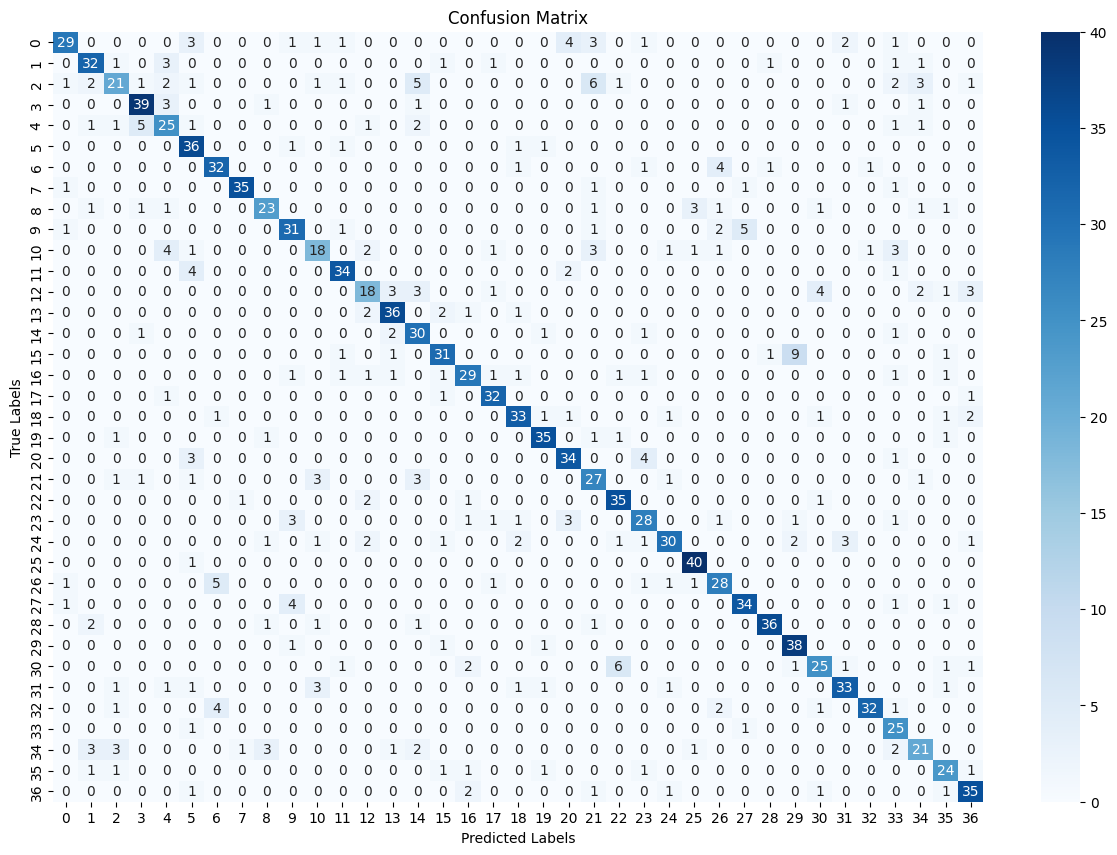

In [192]:
all_labels = []
all_preds = []

def collect_predictions(model, valLoader, device):
    model.eval()
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())

collect_predictions(model, valLoader, device)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(37), yticklabels=range(37))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

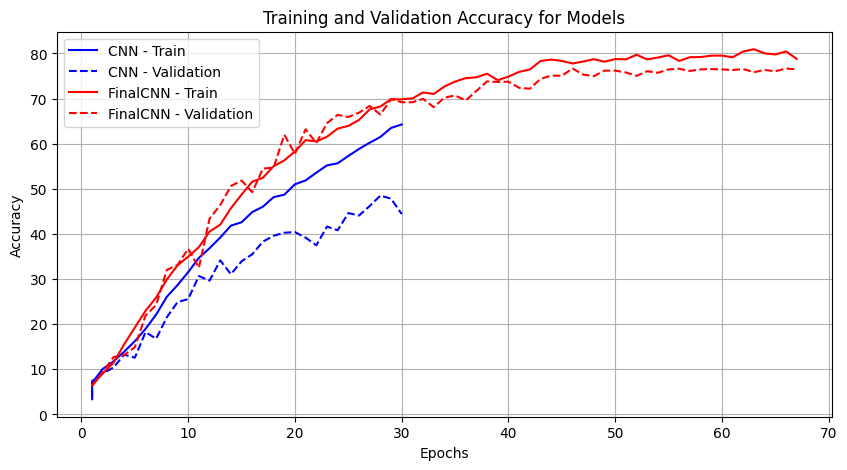

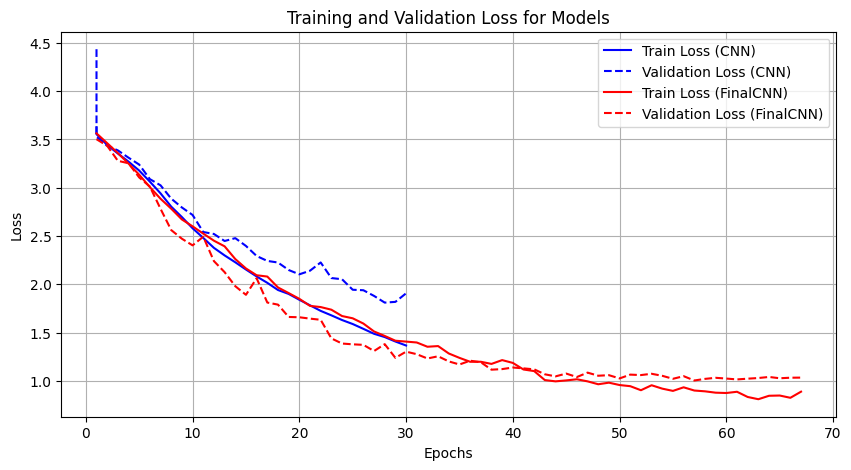

In [198]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

def plot_from_tensorboard(log_dir_1, log_dir_2, labelTrain1, labelVal1, labelTrain2, labelVal2):
    event_acc_1 = EventAccumulator(log_dir_1)
    event_acc_1.Reload()
    trainLoss_1 = event_acc_1.Scalars('train/Loss')
    valLoss_1 = event_acc_1.Scalars('val/Loss')
    trainAccuracy_1 = event_acc_1.Scalars('train/ACC')
    valAccuracy_1 = event_acc_1.Scalars('val/ACC')
    epochs_1 = [s.step for s in trainLoss_1]
    
    event_acc_2 = EventAccumulator(log_dir_2)
    event_acc_2.Reload()
    trainLoss_2 = event_acc_2.Scalars('train/Loss')
    valLoss_2 = event_acc_2.Scalars('val/Loss')
    trainAccuracy_2 = event_acc_2.Scalars('train/ACC')
    valAccuracy_2 = event_acc_2.Scalars('val/ACC')
    epochs_2 = [s.step for s in trainLoss_2]
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_1, [s.value for s in trainAccuracy_1], label=labelTrain1, linestyle='-', color='blue')
    plt.plot(epochs_1, [s.value for s in valAccuracy_1], label=labelVal1, linestyle='--', color='blue')
    plt.plot(epochs_2, [s.value for s in trainAccuracy_2], label=labelTrain2, linestyle='-', color='red')
    plt.plot(epochs_2, [s.value for s in valAccuracy_2], label=labelVal2, linestyle='--', color='red')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_1, [s.value for s in trainLoss_1], label='Train Loss (CNN)', linestyle='-', color='blue')
    plt.plot(epochs_1, [s.value for s in valLoss_1], label='Validation Loss (CNN)', linestyle='--', color='blue')
    plt.plot(epochs_2, [s.value for s in trainLoss_2], label='Train Loss (FinalCNN)', linestyle='-', color='red')
    plt.plot(epochs_2, [s.value for s in valLoss_2], label='Validation Loss (FinalCNN)', linestyle='--', color='red')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Models')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_from_tensorboard('runs/CNN', 'runs/FinalCNN', 'CNN - Train', 'CNN - Validation', 'FinalCNN - Train', 'FinalCNN - Validation')


<h1 style="color: #2B547E; font-weight: bold;">Pre Train Model</h1>

# Resnet50

In [204]:
modelresnet50 = timm.create_model('resnet50', pretrained = True, num_classes=37)

for param in modelresnet50.parameters():
    param.requires_grad = False
for param in modelresnet50.fc.parameters():
    param.requires_grad = True

for name, param in modelresnet50.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.0.conv3.weight: requires_grad=False
layer1.0.bn3.weight: requires_grad=False
layer1.0.bn3.bias: requires_grad=False
layer1.0.downsample.0.weight: requires_grad=False
layer1.0.downsample.1.weight: requires_grad=False
layer1.0.downsample.1.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer1.1.conv3.weight: requires_grad=False
layer1.1.bn3.weight: requires_grad=False
layer1.1.bn3.bias: requires_grad=False
layer1.2.conv1.wei

In [205]:
if device == 'cuda':
  modelresnet50= nn.DataParallel(modelresnet50)
modelresnet50 = modelresnet50.to(device)

In [207]:
optimizer1 = torch.optim.Adam(filter(lambda p: p.requires_grad, modelresnet50.parameters()), lr=0.0001)
train_model(modelresnet50, trainLoader, valLoader, LossFunc, optimizer1, scheduler=None, num_epochs=20 , patience=2, ModelName = 'modelresnet50')

Epoch 1/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=3.41]



Epoch [1/20], Train Loss: 3.5163, Train Accuracy: 17.93%, Val Loss: 3.4158, Val Accuracy: 41.16%
Learning Rate: 0.000100


Epoch 2/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.42it/s, loss=3.18]



Epoch [2/20], Train Loss: 3.3125, Train Accuracy: 50.30%, Val Loss: 3.2349, Val Accuracy: 66.46%
Learning Rate: 0.000100


Epoch 3/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.38it/s, loss=3.03]



Epoch [3/20], Train Loss: 3.1247, Train Accuracy: 66.47%, Val Loss: 3.0577, Val Accuracy: 75.31%
Learning Rate: 0.000100


Epoch 4/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=2.91]



Epoch [4/20], Train Loss: 2.9447, Train Accuracy: 75.76%, Val Loss: 2.9135, Val Accuracy: 78.37%
Learning Rate: 0.000100


Epoch 5/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.38it/s, loss=2.58]



Epoch [5/20], Train Loss: 2.7784, Train Accuracy: 77.56%, Val Loss: 2.7459, Val Accuracy: 80.68%
Learning Rate: 0.000100


Epoch 6/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.39it/s, loss=2.54]



Epoch [6/20], Train Loss: 2.6177, Train Accuracy: 81.56%, Val Loss: 2.5874, Val Accuracy: 82.72%
Learning Rate: 0.000100


Epoch 7/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=2.33]



Epoch [7/20], Train Loss: 2.4688, Train Accuracy: 82.80%, Val Loss: 2.4577, Val Accuracy: 82.31%
Learning Rate: 0.000100


Epoch 8/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.38it/s, loss=2.29]



Epoch [8/20], Train Loss: 2.3299, Train Accuracy: 82.96%, Val Loss: 2.3267, Val Accuracy: 83.33%
Learning Rate: 0.000100


Epoch 9/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=2.14]



Epoch [9/20], Train Loss: 2.2025, Train Accuracy: 83.65%, Val Loss: 2.2260, Val Accuracy: 84.42%
Learning Rate: 0.000100


Epoch 10/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=2.04]



Epoch [10/20], Train Loss: 2.0784, Train Accuracy: 84.47%, Val Loss: 2.1258, Val Accuracy: 84.56%
Learning Rate: 0.000100


Epoch 11/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.40it/s, loss=2.02]



Epoch [11/20], Train Loss: 1.9618, Train Accuracy: 85.03%, Val Loss: 2.0062, Val Accuracy: 85.71%
Learning Rate: 0.000100


Epoch 12/20 [Training]: 100%|██████████| 92/92 [00:39<00:00,  2.36it/s, loss=1.87]



Epoch [12/20], Train Loss: 1.8608, Train Accuracy: 85.90%, Val Loss: 1.9207, Val Accuracy: 84.49%
Learning Rate: 0.000100


Epoch 13/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.39it/s, loss=1.84]



Epoch [13/20], Train Loss: 1.7612, Train Accuracy: 85.68%, Val Loss: 1.7964, Val Accuracy: 84.97%
Learning Rate: 0.000100


Epoch 14/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.38it/s, loss=1.62]



Epoch [14/20], Train Loss: 1.6797, Train Accuracy: 85.78%, Val Loss: 1.7257, Val Accuracy: 85.51%
Learning Rate: 0.000100


Epoch 15/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=1.65]



Epoch [15/20], Train Loss: 1.6011, Train Accuracy: 85.51%, Val Loss: 1.6404, Val Accuracy: 87.07%
Learning Rate: 0.000100


Epoch 16/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.40it/s, loss=1.52]



Epoch [16/20], Train Loss: 1.5084, Train Accuracy: 86.75%, Val Loss: 1.5372, Val Accuracy: 86.33%
Learning Rate: 0.000100


Epoch 17/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=1.56]



Epoch [17/20], Train Loss: 1.4389, Train Accuracy: 86.19%, Val Loss: 1.5119, Val Accuracy: 85.65%
Learning Rate: 0.000100


Epoch 18/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.39it/s, loss=1.6] 



Epoch [18/20], Train Loss: 1.3779, Train Accuracy: 86.53%, Val Loss: 1.4326, Val Accuracy: 86.39%
Learning Rate: 0.000100


Epoch 19/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.41it/s, loss=1.42]



Epoch [19/20], Train Loss: 1.3128, Train Accuracy: 86.83%, Val Loss: 1.3981, Val Accuracy: 86.05%
Learning Rate: 0.000100


Epoch 20/20 [Training]: 100%|██████████| 92/92 [00:38<00:00,  2.37it/s, loss=1.13]
                                                                      


Epoch [20/20], Train Loss: 1.2570, Train Accuracy: 86.87%, Val Loss: 1.3146, Val Accuracy: 86.46%
Learning Rate: 0.000100
training complete.


# mobile net v2

In [219]:
model_v2 = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=37)

for param in model_v2.parameters():
    param.requires_grad = False

for param in model_v2.classifier.parameters():
    param.requires_grad = True

In [220]:
for name, param in model_v2.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv_stem.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
blocks.0.0.conv_dw.weight: requires_grad=False
blocks.0.0.bn1.weight: requires_grad=False
blocks.0.0.bn1.bias: requires_grad=False
blocks.0.0.conv_pw.weight: requires_grad=False
blocks.0.0.bn2.weight: requires_grad=False
blocks.0.0.bn2.bias: requires_grad=False
blocks.1.0.conv_pw.weight: requires_grad=False
blocks.1.0.bn1.weight: requires_grad=False
blocks.1.0.bn1.bias: requires_grad=False
blocks.1.0.conv_dw.weight: requires_grad=False
blocks.1.0.bn2.weight: requires_grad=False
blocks.1.0.bn2.bias: requires_grad=False
blocks.1.0.conv_pwl.weight: requires_grad=False
blocks.1.0.bn3.weight: requires_grad=False
blocks.1.0.bn3.bias: requires_grad=False
blocks.1.1.conv_pw.weight: requires_grad=False
blocks.1.1.bn1.weight: requires_grad=False
blocks.1.1.bn1.bias: requires_grad=False
blocks.1.1.conv_dw.weight: requires_grad=False
blocks.1.1.bn2.weight: requires_grad=False
blocks.1.1.bn2.bias: re

In [221]:
if device == 'cuda':
  model_v2= nn.DataParallel(model_v2)
model_v2 = model_v2.to(device)


In [222]:
optimizer2 = torch.optim.Adam(filter(lambda p: p.requires_grad, model_v2.parameters()), lr=0.0001)
train_model(model_v2, trainLoader, valLoader, LossFunc, optimizer2, scheduler=None, num_epochs=20 , patience=2, ModelName = 'model_v2')

Epoch 1/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.50it/s, loss=3.67]



Epoch [1/20], Train Loss: 4.0040, Train Accuracy: 4.83%, Val Loss: 3.7021, Val Accuracy: 7.69%
Learning Rate: 0.000100


Epoch 2/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=3.19]



Epoch [2/20], Train Loss: 3.4730, Train Accuracy: 10.22%, Val Loss: 3.2800, Val Accuracy: 14.35%
Learning Rate: 0.000100


Epoch 3/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.49it/s, loss=2.76]



Epoch [3/20], Train Loss: 3.0575, Train Accuracy: 18.40%, Val Loss: 2.9310, Val Accuracy: 22.52%
Learning Rate: 0.000100


Epoch 4/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.45it/s, loss=2.7] 



Epoch [4/20], Train Loss: 2.7415, Train Accuracy: 25.89%, Val Loss: 2.6386, Val Accuracy: 30.54%
Learning Rate: 0.000100


Epoch 5/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.46it/s, loss=2.42]



Epoch [5/20], Train Loss: 2.4589, Train Accuracy: 34.77%, Val Loss: 2.3941, Val Accuracy: 37.28%
Learning Rate: 0.000100


Epoch 6/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=2.11]



Epoch [6/20], Train Loss: 2.2163, Train Accuracy: 40.72%, Val Loss: 2.1949, Val Accuracy: 41.97%
Learning Rate: 0.000100


Epoch 7/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.48it/s, loss=1.95]



Epoch [7/20], Train Loss: 2.0173, Train Accuracy: 45.99%, Val Loss: 2.0141, Val Accuracy: 45.78%
Learning Rate: 0.000100


Epoch 8/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.46it/s, loss=1.97]



Epoch [8/20], Train Loss: 1.8494, Train Accuracy: 51.76%, Val Loss: 1.8565, Val Accuracy: 50.27%
Learning Rate: 0.000100


Epoch 9/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.48it/s, loss=1.7] 



Epoch [9/20], Train Loss: 1.7207, Train Accuracy: 54.31%, Val Loss: 1.7600, Val Accuracy: 52.11%
Learning Rate: 0.000100


Epoch 10/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=1.59]



Epoch [10/20], Train Loss: 1.6025, Train Accuracy: 57.41%, Val Loss: 1.6290, Val Accuracy: 56.39%
Learning Rate: 0.000100


Epoch 11/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=1.19]



Epoch [11/20], Train Loss: 1.5009, Train Accuracy: 60.79%, Val Loss: 1.5618, Val Accuracy: 57.41%
Learning Rate: 0.000100


Epoch 12/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.43it/s, loss=1.41]



Epoch [12/20], Train Loss: 1.4120, Train Accuracy: 62.61%, Val Loss: 1.4520, Val Accuracy: 61.02%
Learning Rate: 0.000100


Epoch 13/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=1.14]



Epoch [13/20], Train Loss: 1.3492, Train Accuracy: 64.60%, Val Loss: 1.3787, Val Accuracy: 62.99%
Learning Rate: 0.000100


Epoch 14/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.45it/s, loss=1.37]



Epoch [14/20], Train Loss: 1.2779, Train Accuracy: 65.67%, Val Loss: 1.3503, Val Accuracy: 62.72%
Learning Rate: 0.000100


Epoch 15/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.50it/s, loss=1.04] 



Epoch [15/20], Train Loss: 1.2230, Train Accuracy: 67.94%, Val Loss: 1.2996, Val Accuracy: 64.29%
Learning Rate: 0.000100


Epoch 16/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.46it/s, loss=1.04] 



Epoch [16/20], Train Loss: 1.1543, Train Accuracy: 68.86%, Val Loss: 1.2511, Val Accuracy: 65.17%
Learning Rate: 0.000100


Epoch 17/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.48it/s, loss=1.07] 



Epoch [17/20], Train Loss: 1.1088, Train Accuracy: 70.85%, Val Loss: 1.1884, Val Accuracy: 66.80%
Learning Rate: 0.000100


Epoch 18/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.46it/s, loss=1.09] 



Epoch [18/20], Train Loss: 1.0787, Train Accuracy: 70.83%, Val Loss: 1.1445, Val Accuracy: 68.50%
Learning Rate: 0.000100


Epoch 19/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=1.08] 



Epoch [19/20], Train Loss: 1.0235, Train Accuracy: 73.18%, Val Loss: 1.1298, Val Accuracy: 68.57%
Learning Rate: 0.000100


Epoch 20/20 [Training]: 100%|██████████| 92/92 [00:37<00:00,  2.47it/s, loss=0.921]
                                                                       


Epoch [20/20], Train Loss: 1.0054, Train Accuracy: 72.97%, Val Loss: 1.0980, Val Accuracy: 69.12%
Learning Rate: 0.000100
training complete.


In [225]:
modelx = timm.create_model('xception', pretrained=True, num_classes=37)

for param in modelx.parameters():
    param.requires_grad = False

for param in modelx.fc.parameters():
    param.requires_grad = True

In [226]:
for name, param in modelx.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
conv2.weight: requires_grad=False
bn2.weight: requires_grad=False
bn2.bias: requires_grad=False
block1.skip.weight: requires_grad=False
block1.skipbn.weight: requires_grad=False
block1.skipbn.bias: requires_grad=False
block1.rep.0.conv1.weight: requires_grad=False
block1.rep.0.pointwise.weight: requires_grad=False
block1.rep.1.weight: requires_grad=False
block1.rep.1.bias: requires_grad=False
block1.rep.3.conv1.weight: requires_grad=False
block1.rep.3.pointwise.weight: requires_grad=False
block1.rep.4.weight: requires_grad=False
block1.rep.4.bias: requires_grad=False
block2.skip.weight: requires_grad=False
block2.skipbn.weight: requires_grad=False
block2.skipbn.bias: requires_grad=False
block2.rep.1.conv1.weight: requires_grad=False
block2.rep.1.pointwise.weight: requires_grad=False
block2.rep.2.weight: requires_grad=False
block2.rep.2.bias: requires_grad=False
block2.rep.4.conv1.weight: req

In [227]:
if device == 'cuda':
  modelx= nn.DataParallel(modelx)
modelx = model_v2.to(device)


In [228]:
optimizer3 = torch.optim.Adam(filter(lambda p: p.requires_grad, modelx.parameters()), lr=0.0001)
train_model(modelx, trainLoader, valLoader, LossFunc, optimizer3, scheduler=None, num_epochs=20 , patience=2 , ModelName = 'modelx')

Epoch 1/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.55it/s, loss=1.1]  



Epoch [1/20], Train Loss: 0.9619, Train Accuracy: 74.25%, Val Loss: 1.0681, Val Accuracy: 70.34%
Learning Rate: 0.000100


Epoch 2/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.53it/s, loss=0.859]



Epoch [2/20], Train Loss: 0.9410, Train Accuracy: 74.11%, Val Loss: 1.0378, Val Accuracy: 70.82%
Learning Rate: 0.000100


Epoch 3/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.53it/s, loss=0.741]



Epoch [3/20], Train Loss: 0.8975, Train Accuracy: 75.90%, Val Loss: 1.0093, Val Accuracy: 71.63%
Learning Rate: 0.000100


Epoch 4/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.53it/s, loss=0.878]



Epoch [4/20], Train Loss: 0.8706, Train Accuracy: 76.25%, Val Loss: 1.0069, Val Accuracy: 71.02%
Learning Rate: 0.000100


Epoch 5/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.55it/s, loss=0.903]



Epoch [5/20], Train Loss: 0.8380, Train Accuracy: 77.73%, Val Loss: 0.9568, Val Accuracy: 72.52%
Learning Rate: 0.000100


Epoch 6/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.53it/s, loss=0.778]



Epoch [6/20], Train Loss: 0.8269, Train Accuracy: 77.41%, Val Loss: 0.9585, Val Accuracy: 72.24%
Learning Rate: 0.000100


Epoch 7/20 [Training]: 100%|██████████| 92/92 [00:35<00:00,  2.56it/s, loss=0.68] 



Epoch [7/20], Train Loss: 0.7886, Train Accuracy: 78.50%, Val Loss: 0.9014, Val Accuracy: 74.08%
Learning Rate: 0.000100


Epoch 8/20 [Training]: 100%|██████████| 92/92 [00:36<00:00,  2.53it/s, loss=0.718]



Epoch [8/20], Train Loss: 0.7781, Train Accuracy: 78.60%, Val Loss: 0.9138, Val Accuracy: 73.74%
Learning Rate: 0.000100


Epoch 9/20 [Training]: 100%|██████████| 92/92 [00:35<00:00,  2.57it/s, loss=0.843]
                                                                       


Epoch [9/20], Train Loss: 0.7623, Train Accuracy: 78.70%, Val Loss: 0.9149, Val Accuracy: 73.13%
Learning Rate: 0.000100
Early stopping triggered at epoch 9
training complete.


In [230]:
modelt = timm.create_model('tresnet_l', pretrained=True, num_classes=37)


for param in modelt.body.parameters():
    param.requires_grad = False

for param in modelt.head.parameters():
    param.requires_grad = True

In [231]:
for name, param in modelt.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

body.conv1.conv.weight: requires_grad=False
body.conv1.bn.weight: requires_grad=False
body.conv1.bn.bias: requires_grad=False
body.layer1.0.conv1.conv.weight: requires_grad=False
body.layer1.0.conv1.bn.weight: requires_grad=False
body.layer1.0.conv1.bn.bias: requires_grad=False
body.layer1.0.conv2.conv.weight: requires_grad=False
body.layer1.0.conv2.bn.weight: requires_grad=False
body.layer1.0.conv2.bn.bias: requires_grad=False
body.layer1.0.se.fc1.weight: requires_grad=False
body.layer1.0.se.fc1.bias: requires_grad=False
body.layer1.0.se.fc2.weight: requires_grad=False
body.layer1.0.se.fc2.bias: requires_grad=False
body.layer1.1.conv1.conv.weight: requires_grad=False
body.layer1.1.conv1.bn.weight: requires_grad=False
body.layer1.1.conv1.bn.bias: requires_grad=False
body.layer1.1.conv2.conv.weight: requires_grad=False
body.layer1.1.conv2.bn.weight: requires_grad=False
body.layer1.1.conv2.bn.bias: requires_grad=False
body.layer1.1.se.fc1.weight: requires_grad=False
body.layer1.1.se.fc1.

In [233]:
if device == 'cuda':
  modelt= nn.DataParallel(modelt)
modelt = modelt.to(device)


In [234]:
optimizer4 = torch.optim.Adam(filter(lambda p: p.requires_grad, modelt.parameters()), lr=0.0001)
train_model(modelt, trainLoader, valLoader, LossFunc, optimizer4, scheduler=None, num_epochs=20 , patience=2 , ModelName='modelt')

Epoch 1/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=2.49]



Epoch [1/20], Train Loss: 3.0240, Train Accuracy: 40.28%, Val Loss: 2.4999, Val Accuracy: 73.54%
Learning Rate: 0.000100


Epoch 2/20 [Training]: 100%|██████████| 92/92 [00:44<00:00,  2.06it/s, loss=1.83]



Epoch [2/20], Train Loss: 2.0540, Train Accuracy: 77.82%, Val Loss: 1.7617, Val Accuracy: 82.93%
Learning Rate: 0.000100


Epoch 3/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=1.33]



Epoch [3/20], Train Loss: 1.4757, Train Accuracy: 82.53%, Val Loss: 1.3025, Val Accuracy: 84.97%
Learning Rate: 0.000100


Epoch 4/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.942]



Epoch [4/20], Train Loss: 1.1255, Train Accuracy: 85.27%, Val Loss: 1.0337, Val Accuracy: 85.99%
Learning Rate: 0.000100


Epoch 5/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.02it/s, loss=0.759]



Epoch [5/20], Train Loss: 0.9105, Train Accuracy: 86.51%, Val Loss: 0.8727, Val Accuracy: 86.60%
Learning Rate: 0.000100


Epoch 6/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.82] 



Epoch [6/20], Train Loss: 0.7772, Train Accuracy: 88.01%, Val Loss: 0.7474, Val Accuracy: 86.94%
Learning Rate: 0.000100


Epoch 7/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.619]



Epoch [7/20], Train Loss: 0.6855, Train Accuracy: 87.96%, Val Loss: 0.6835, Val Accuracy: 87.01%
Learning Rate: 0.000100


Epoch 8/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.03it/s, loss=0.706]



Epoch [8/20], Train Loss: 0.6193, Train Accuracy: 88.25%, Val Loss: 0.6223, Val Accuracy: 86.80%
Learning Rate: 0.000100


Epoch 9/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.632]



Epoch [9/20], Train Loss: 0.5684, Train Accuracy: 89.25%, Val Loss: 0.5718, Val Accuracy: 87.69%
Learning Rate: 0.000100


Epoch 10/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.03it/s, loss=0.38] 



Epoch [10/20], Train Loss: 0.5198, Train Accuracy: 89.57%, Val Loss: 0.5360, Val Accuracy: 88.16%
Learning Rate: 0.000100


Epoch 11/20 [Training]: 100%|██████████| 92/92 [00:44<00:00,  2.05it/s, loss=0.521]



Epoch [11/20], Train Loss: 0.4790, Train Accuracy: 90.63%, Val Loss: 0.5147, Val Accuracy: 88.03%
Learning Rate: 0.000100


Epoch 12/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.492]



Epoch [12/20], Train Loss: 0.4561, Train Accuracy: 90.85%, Val Loss: 0.4809, Val Accuracy: 88.23%
Learning Rate: 0.000100


Epoch 13/20 [Training]: 100%|██████████| 92/92 [00:44<00:00,  2.05it/s, loss=0.501]



Epoch [13/20], Train Loss: 0.4241, Train Accuracy: 91.15%, Val Loss: 0.4729, Val Accuracy: 88.10%
Learning Rate: 0.000100


Epoch 14/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.03it/s, loss=0.342]



Epoch [14/20], Train Loss: 0.4134, Train Accuracy: 91.39%, Val Loss: 0.4452, Val Accuracy: 89.18%
Learning Rate: 0.000100


Epoch 15/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.03it/s, loss=0.359]



Epoch [15/20], Train Loss: 0.3924, Train Accuracy: 91.36%, Val Loss: 0.4331, Val Accuracy: 89.39%
Learning Rate: 0.000100


Epoch 16/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.01it/s, loss=0.259]



Epoch [16/20], Train Loss: 0.3747, Train Accuracy: 92.04%, Val Loss: 0.4221, Val Accuracy: 89.12%
Learning Rate: 0.000100


Epoch 17/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.379]



Epoch [17/20], Train Loss: 0.3558, Train Accuracy: 92.46%, Val Loss: 0.4112, Val Accuracy: 88.84%
Learning Rate: 0.000100


Epoch 18/20 [Training]: 100%|██████████| 92/92 [00:44<00:00,  2.05it/s, loss=0.327]



Epoch [18/20], Train Loss: 0.3464, Train Accuracy: 91.80%, Val Loss: 0.4077, Val Accuracy: 89.39%
Learning Rate: 0.000100


Epoch 19/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.261]



Epoch [19/20], Train Loss: 0.3347, Train Accuracy: 92.58%, Val Loss: 0.3879, Val Accuracy: 89.12%
Learning Rate: 0.000100


Epoch 20/20 [Training]: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.379]
                                                                       


Epoch [20/20], Train Loss: 0.3184, Train Accuracy: 93.03%, Val Loss: 0.3859, Val Accuracy: 88.98%
Learning Rate: 0.000100
training complete.


<h1 style="color: #2B547E; font-weight: bold;">Pre Train Model With FineTune</h1>

In [236]:
modeltf = timm.create_model('tresnet_l', pretrained=True, num_classes=37)

for param in modeltf.body.parameters():
    param.requires_grad = False

for name, param in modeltf.named_parameters():
    if "layer3" in name or "layer4" in name or "head" in name:
        param.requires_grad = True

In [237]:
for name, param in modeltf.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

body.conv1.conv.weight: requires_grad=False
body.conv1.bn.weight: requires_grad=False
body.conv1.bn.bias: requires_grad=False
body.layer1.0.conv1.conv.weight: requires_grad=False
body.layer1.0.conv1.bn.weight: requires_grad=False
body.layer1.0.conv1.bn.bias: requires_grad=False
body.layer1.0.conv2.conv.weight: requires_grad=False
body.layer1.0.conv2.bn.weight: requires_grad=False
body.layer1.0.conv2.bn.bias: requires_grad=False
body.layer1.0.se.fc1.weight: requires_grad=False
body.layer1.0.se.fc1.bias: requires_grad=False
body.layer1.0.se.fc2.weight: requires_grad=False
body.layer1.0.se.fc2.bias: requires_grad=False
body.layer1.1.conv1.conv.weight: requires_grad=False
body.layer1.1.conv1.bn.weight: requires_grad=False
body.layer1.1.conv1.bn.bias: requires_grad=False
body.layer1.1.conv2.conv.weight: requires_grad=False
body.layer1.1.conv2.bn.weight: requires_grad=False
body.layer1.1.conv2.bn.bias: requires_grad=False
body.layer1.1.se.fc1.weight: requires_grad=False
body.layer1.1.se.fc1.

In [238]:
if device == 'cuda':
  modeltf= nn.DataParallel(modeltf)
modeltf = modeltf.to(device)

In [250]:
optimizer5 = torch.optim.Adam(filter(lambda p: p.requires_grad, modeltf.parameters()), lr=0.00001)
train_model(modeltf, trainLoader, valLoader, LossFunc, optimizer5, scheduler=None, num_epochs=20 , patience=5 , ModelName= 'modeltf' )

Epoch 1/20 [Training]: 100%|██████████| 92/92 [00:56<00:00,  1.64it/s, loss=0.0259] 



Epoch [1/20], Train Loss: 0.0413, Train Accuracy: 99.08%, Val Loss: 0.1820, Val Accuracy: 94.49%
Learning Rate: 0.000010


Epoch 2/20 [Training]: 100%|██████████| 92/92 [00:57<00:00,  1.61it/s, loss=0.128]  



Epoch [2/20], Train Loss: 0.0382, Train Accuracy: 99.08%, Val Loss: 0.2048, Val Accuracy: 94.22%
Learning Rate: 0.000010


Epoch 3/20 [Training]: 100%|██████████| 92/92 [00:57<00:00,  1.60it/s, loss=0.0753] 



Epoch [3/20], Train Loss: 0.0276, Train Accuracy: 99.47%, Val Loss: 0.1835, Val Accuracy: 94.76%
Learning Rate: 0.000010


Epoch 4/20 [Training]: 100%|██████████| 92/92 [00:57<00:00,  1.59it/s, loss=0.0676] 



Epoch [4/20], Train Loss: 0.0265, Train Accuracy: 99.54%, Val Loss: 0.1869, Val Accuracy: 94.56%
Learning Rate: 0.000010


Epoch 5/20 [Training]: 100%|██████████| 92/92 [00:57<00:00,  1.59it/s, loss=0.0439] 



Epoch [5/20], Train Loss: 0.0275, Train Accuracy: 99.44%, Val Loss: 0.1903, Val Accuracy: 94.63%
Learning Rate: 0.000010


Epoch 6/20 [Training]: 100%|██████████| 92/92 [00:57<00:00,  1.59it/s, loss=0.0311] 
                                                                        


Epoch [6/20], Train Loss: 0.0227, Train Accuracy: 99.49%, Val Loss: 0.2125, Val Accuracy: 93.81%
Learning Rate: 0.000010
Early stopping triggered at epoch 6
training complete.


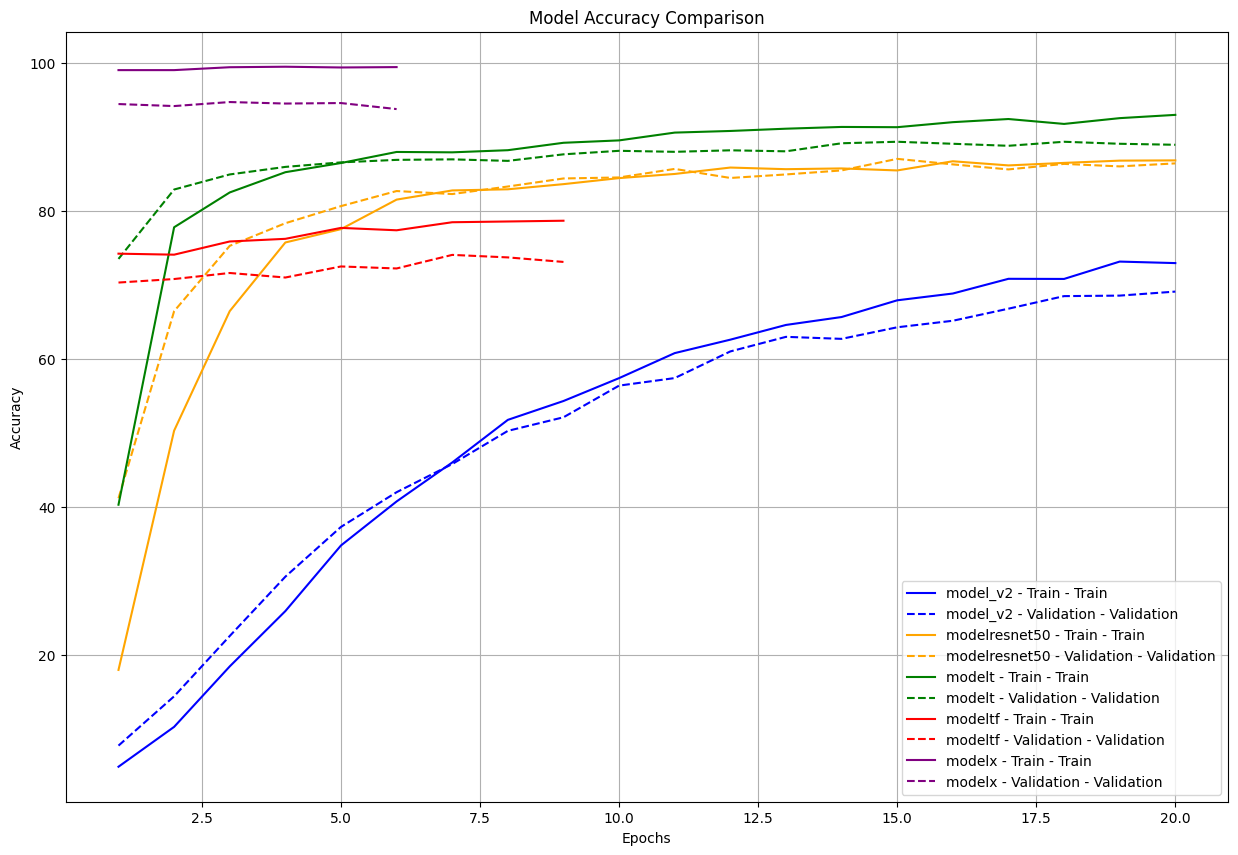

In [258]:
def plot_from_tensorboard(log_dirs, labels):
    plt.figure(figsize=(15, 10))
    
    train_line_style = '-'  
    val_line_style = '--'   
    colors = ['blue', 'orange', 'green', 'red' ,'purple']
    
    for i in range(len(log_dirs)):
        log_dir = log_dirs[i]
        labelTrain, labelVal = labels[i]
        
        event_acc = EventAccumulator(log_dir)
        event_acc.Reload()
        trainLoss = event_acc.Scalars('train/Loss')
        valLoss = event_acc.Scalars('val/Loss')
        trainAccuracy = event_acc.Scalars('train/ACC')
        valAccuracy = event_acc.Scalars('val/ACC')
        epochs = [s.step for s in trainLoss]

        plt.plot(epochs, [s.value for s in trainAccuracy], label=f'{labelTrain} - Train', linestyle=train_line_style, color=colors[i])
        plt.plot(epochs, [s.value for s in valAccuracy], label=f'{labelVal} - Validation', linestyle=val_line_style, color=colors[i])

    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

log_dirs = ['runs/model_v2', 'runs/modelresnet50', 'runs/modelt', 'runs/modelx','runs/modeltf']  # Log directories
labels = [
    ('model_v2 - Train', 'model_v2 - Validation'),
    ('modelresnet50 - Train', 'modelresnet50 - Validation'),
    ('modelt - Train', 'modelt - Validation'),
    ('modeltf - Train', 'modeltf - Validation'),
    ('modelx - Train', 'modelx - Validation')]

plot_from_tensorboard(log_dirs, labels)
